# Instalação de Dependências

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Informações
Rodadas: 14 com 2 turnos (mandantes diferentes nos jogos)
Por exemplo, se no primeiro turno DFC era o mandante contra TFC, no segundo TFC
Cada turno, está implícito que todos os times devem jogar entre si.

Para cada rodada será rodado o algoritmo de coloração com os times existentes.
As restrições serão de forma que, além daquelas descritas na especificação, se um time já jogou com o outro no mesmo turno então não podem jogar novamente (vizinhos).

Vou tentar colorir com o mínimo de cores possíveis. Se tem a mesma cor quer dizer que pode jogar junto.
Se cor > 


# Códigos Base

In [18]:
from typing import List, Tuple
from dataclasses import dataclass


# Significa que os times dentro desta tupla não
# podem ser mandantes na mesma rodada
@dataclass
class HostRestrict:
    hosts: Tuple[str, str]


# Esse jogo não pode acontencer nesta rodada.
# Atenção: O mandante importa.
@dataclass
class GameRestrict:
    host: str
    other: str


@dataclass
class Time:
    id: int
    name: str

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

from typing import Mapping, List, Tuple


class Graph:
    def __init__(self, nodes: List[Time]):
        self._graph = nx.Graph()
        self._pos: Mapping = None

        # Número de vértices
        self.nodes = nodes
        self.edges: List[Tuple[Time, Time]] = []

        # Lista de adjacência
        self._neighbours = [[] for _ in nodes]

        self._draw_params = {
            "with_labels": True,
            "node_color": "skyblue",
            "node_size": 100,
            "edge_color": "gray",
            "font_weight": "bold",
            "font_size": 8,
        }

    def neighbours(self, v: Time) -> List[Time]:
        # Função auxiliadora para encontrar vizinhos de um vértice.
        # Subtraímos 1 pois a nossa lista começa em 0.
        return self._neighbours[v.id - 1]
    
    def insert_edge(self, v1: Time, v2: Time):
        self._graph.add_edge(v1.name, v2.name)
        self.edges.append((v1, v2))

        self.neighbours(v1).append(v2)
        self.neighbours(v2).append(v1)

    def has_edge(self, v1: Time, v2: Time):
        v2 in self.neighbours(v1)

    def node_degree(self, v: Time) -> int:
        return len(self.neighbours(v))

    def _reload_pos(self):
        self._pos = nx.spring_layout(self._graph)

    def _load_pos(self):
        if self._pos is None:
            self._reload_pos()

    def _create_view(self):
        self._load_pos()

        plt.figure(3, figsize=(12, 12))
        nx.draw(self._graph, pos=self._pos, alpha=0.9, **self._draw_params)

    def view(self):
        self._create_view()
        plt.title("Jogos")
        plt.show()

In [37]:
from typing import Dict


class Game:
    def __init__(self, teams: List[str], rounds: List[int]):
        self.teams = teams
        self.rounds = rounds
        self.max_rounds = sum(rounds)

        self.rounds_played: List[List[Tuple[int]]] = []

        self.host_restrictions: List[HostRestrict] = []
        self.game_restrictions: List[List[GameRestrict]] = [
            [] for _ in range(self.max_rounds)
        ]

        self._teams_map: Dict[str, int] = {}
        self._load_teams_map()

    def _load_teams_map(self):
        for i, team in enumerate(self.teams):
            self._teams_map[team] = i

    def lookup_team(self, team: str) -> int:
        return self._teams_map[team]

    def ruler_teams(self) -> List[str]:
        ruler_teams: List[str] = []
        for team in self.teams:
            ruler_teams.append(f"M{team}")
        for team in self.teams:
            ruler_teams.append(f"N{team}")

        return ruler_teams

    def lookup_ruler_team(self, team: str, ruler: bool) -> int:
        team_id = self.lookup_team(team)
        return (
            Time(team_id, f"M{team}")
            if ruler
            else Time(team_id + len(self.teams), f"N{team}")
        )

    def insert_host_restriction(self, hosts: Tuple[str, str]):
        self.host_restrictions.append(HostRestrict(hosts))

    def insert_game_restriction(self, rounds: List[int], host: str, other: str):
        restrict = GameRestrict(host, other)
        for round in rounds:
            if round > self.max_rounds:
                raise ValueError(f"O jogo tem apenas {self.rounds} rodadas.")

            self.game_restrictions[round - 1].append(restrict)

    def build_graph(self):
        # Criar grafo com times duplicados
        # Times terão inicial M para mandantes e N para não-mandantes.
        graph = Graph(self.ruler_teams())

        # Obviamente existirá uma restrição para mesmos times
        for team in self.teams:
            ruler, not_ruler = [self.lookup_ruler_team(team, b) for b in [True, False]]
            graph.insert_edge(ruler, not_ruler)

        # Além disso mandantes não podem fazer jogos com outros mandantes
        # E não-mandantes não podem fazer jogos com outros.
        for team1 in self.teams:
            mteam1 = self.lookup_ruler_team(team1, True)
            nteam1 = self.lookup_ruler_team(team1, False)

            for team2 in self.teams:
                mteam2 = self.lookup_ruler_team(team2, True)
                nteam2 = self.lookup_ruler_team(team2, False)

                graph.insert_edge(mteam1, mteam2)
                graph.insert_edge(nteam1, nteam2)

        round = len(self.rounds_played)
        for restriction in self.game_restrictions[round - 1]:
            host = self.lookup_ruler_team(restriction.host, True)
            other = self.lookup_ruler_team(restriction.other, False)

            graph.insert_edge(host, other)

        for restriction in self.host_restrictions:
            first, second = restriction.hosts
            host_1 = self.lookup_ruler_team(first, True)
            host_2 = self.lookup_ruler_team(second, True)

            graph.insert_edge(host_1, host_2)

        return graph

    def play_round(self) -> List[Tuple[int]]:
        pass

In [38]:
times, rounds = ["DFC", "TFC", "AFC", "LFC", "FFC", "OFC", "CFC"], [7, 7]
game = Game(times, rounds)

game.insert_game_restriction([1, 14], "DFC", "CFC")

game.insert_host_restriction(("TFC", "OFC"))
game.insert_host_restriction(("AFC", "FFC"))

game.insert_game_restriction([7, 13], "LFC", "FFC")
game.insert_game_restriction([10, 11], "OFC", "LFC")
game.insert_game_restriction([12, 13], "AFC", "FFC")
game.insert_game_restriction([2, 3], "CFC", "TFC")

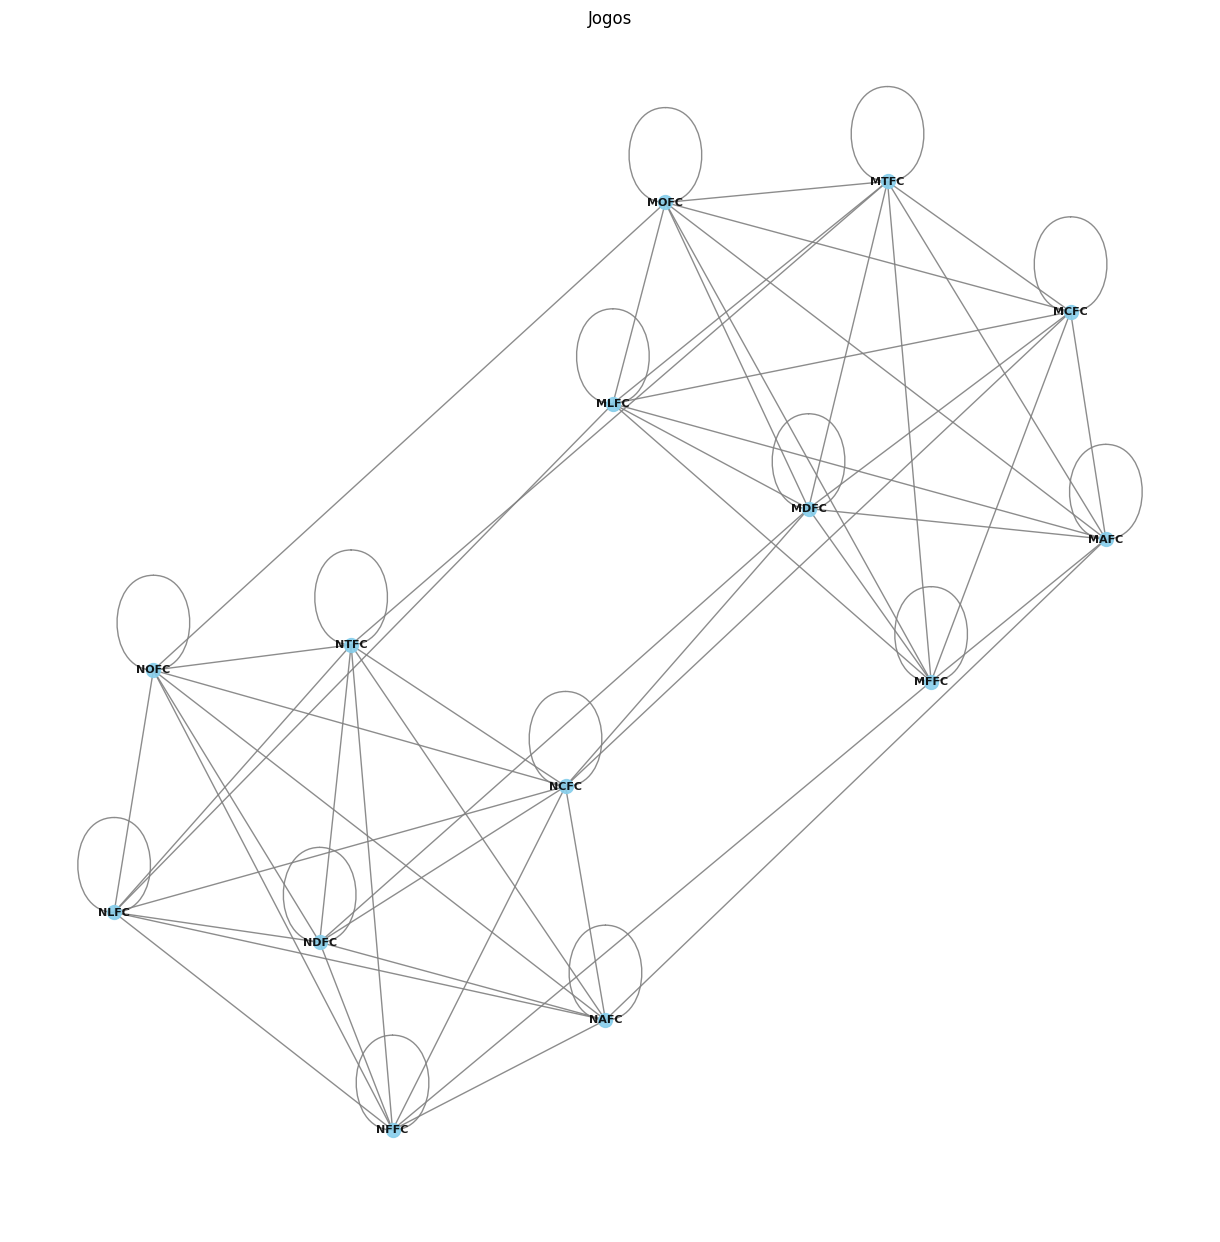

In [39]:
graph = game.build_graph()
graph.view()

# Populando o grafo
Aqui populamos o grafo de acordo com os dados fornecidos. Elos no nosso grafo acontecem quando um emparelhamento é possível. Neste caso, quando a nota do estudante é igual ou superior à nota mínima do projeto e quando o projeto se encontra dentro da lista de prenferências do estudante. 

In [55]:
parser = Parser()
graph = Graph(parser, 55, 200)

with open("./students_projects.txt", "r") as students_file:
    for line in students_file.readlines():
        parsed = parser.parse(line)
        if parsed is not None:
            if isinstance(parsed, Student):
                graph.insert_node_student(parsed)
            else:
                graph.insert_node_project(parsed)

for student in graph.students:
    for project_id in student.prefered_projects:
        project = graph.projects[project_id]
        if student.grade >= project.min_grade:
            graph.insert_edge_project(project.code, student.code)

Podemos visualizar o grafo. Aqui vemos todos os possíveis emparelnhamentos.

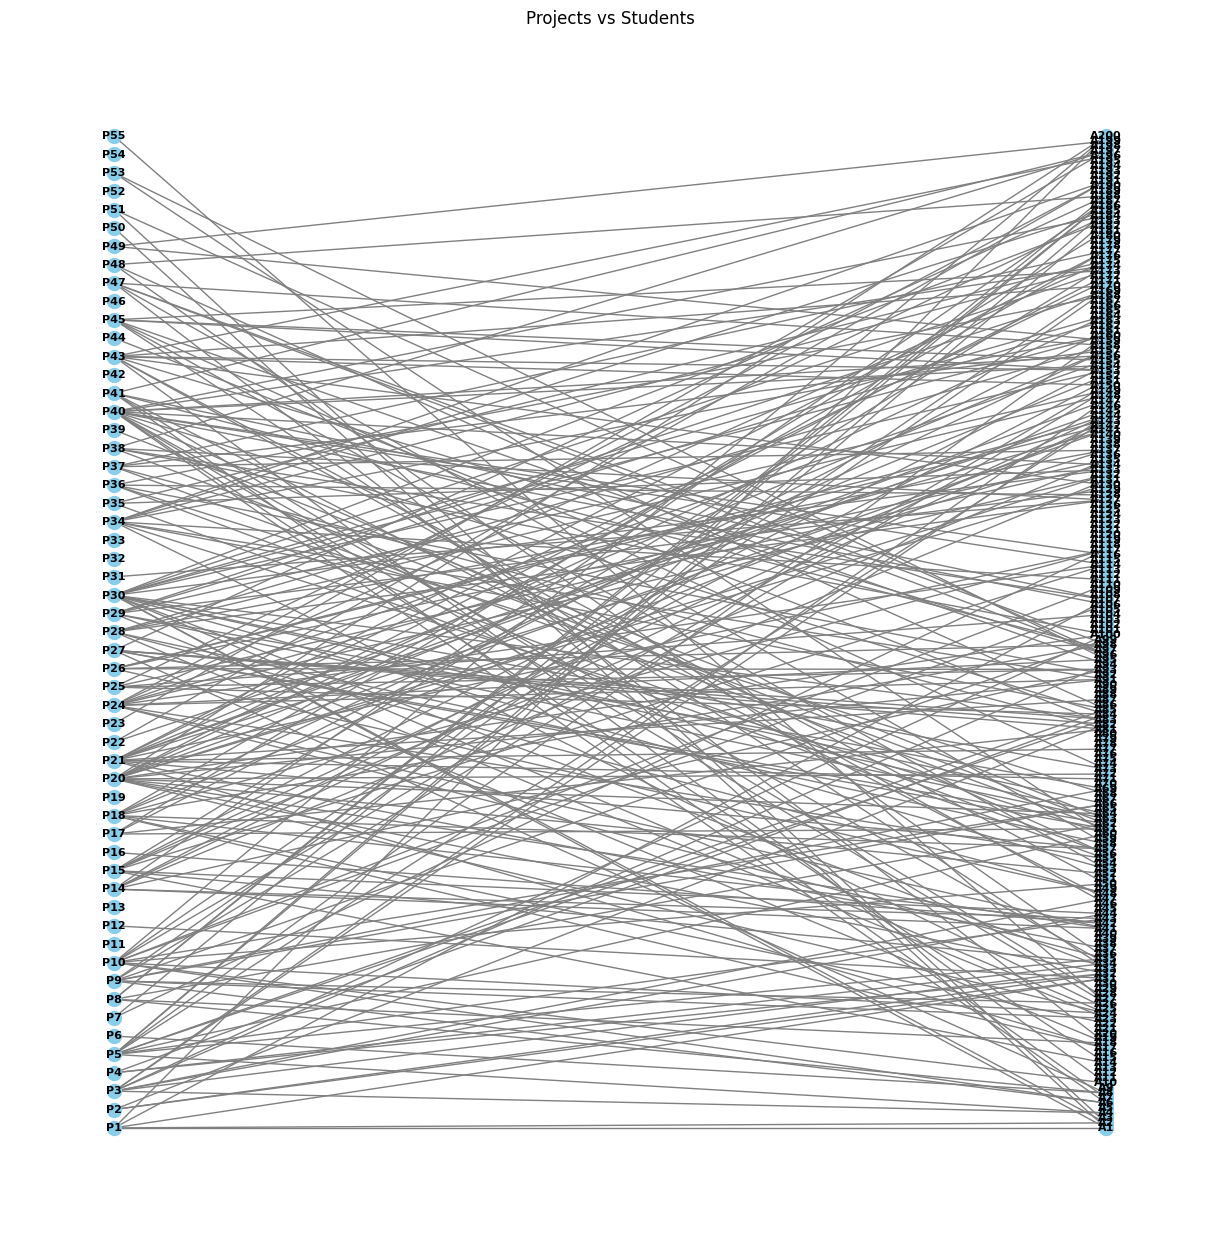

In [7]:
graph.view()

# Emparelhamento Estável
Aqui podemos ver o algoritmo Gale-Shapeley sendo executado uma vez, podemos ver todos os momentos onde um estudante é ligado a um projeto e também quando um estudante é substituído. É fácil ver através das mensagens que o comportamento do algoritmo está seguindo de forma adequada.

Ligando A164 ao projeto P30 (vagas 1), já que existem vagas disponíveis.
Ligando A71 ao projeto P21 (vagas 1), já que existem vagas disponíveis.
Ligando A92 ao projeto P36 (vagas 2), já que existem vagas disponíveis.
Ligando A174 ao projeto P34 (vagas 1), já que existem vagas disponíveis.
Ligando A170 ao projeto P43 (vagas 1), já que existem vagas disponíveis.
Ligando A161 ao projeto P17 (vagas 1), já que existem vagas disponíveis.
Ligando A197 ao projeto P41 (vagas 2), já que existem vagas disponíveis.
Ligando A72 ao projeto P20 (vagas 1), já que existem vagas disponíveis.
Ligando A94 ao projeto P3 (vagas 2), já que existem vagas disponíveis.
Ligando A135 ao projeto P15 (vagas 2), já que existem vagas disponíveis.
Ligando A83 ao projeto P27 (vagas 2), já que existem vagas disponíveis.
Ligando A173 ao projeto P45 (vagas 1), já que existem vagas disponíveis.
Ligando A104 ao projeto P25 (vagas 1), já que existem vagas disponíveis.
Ligando A157 ao projeto P37 (vagas 1), já que existem vag

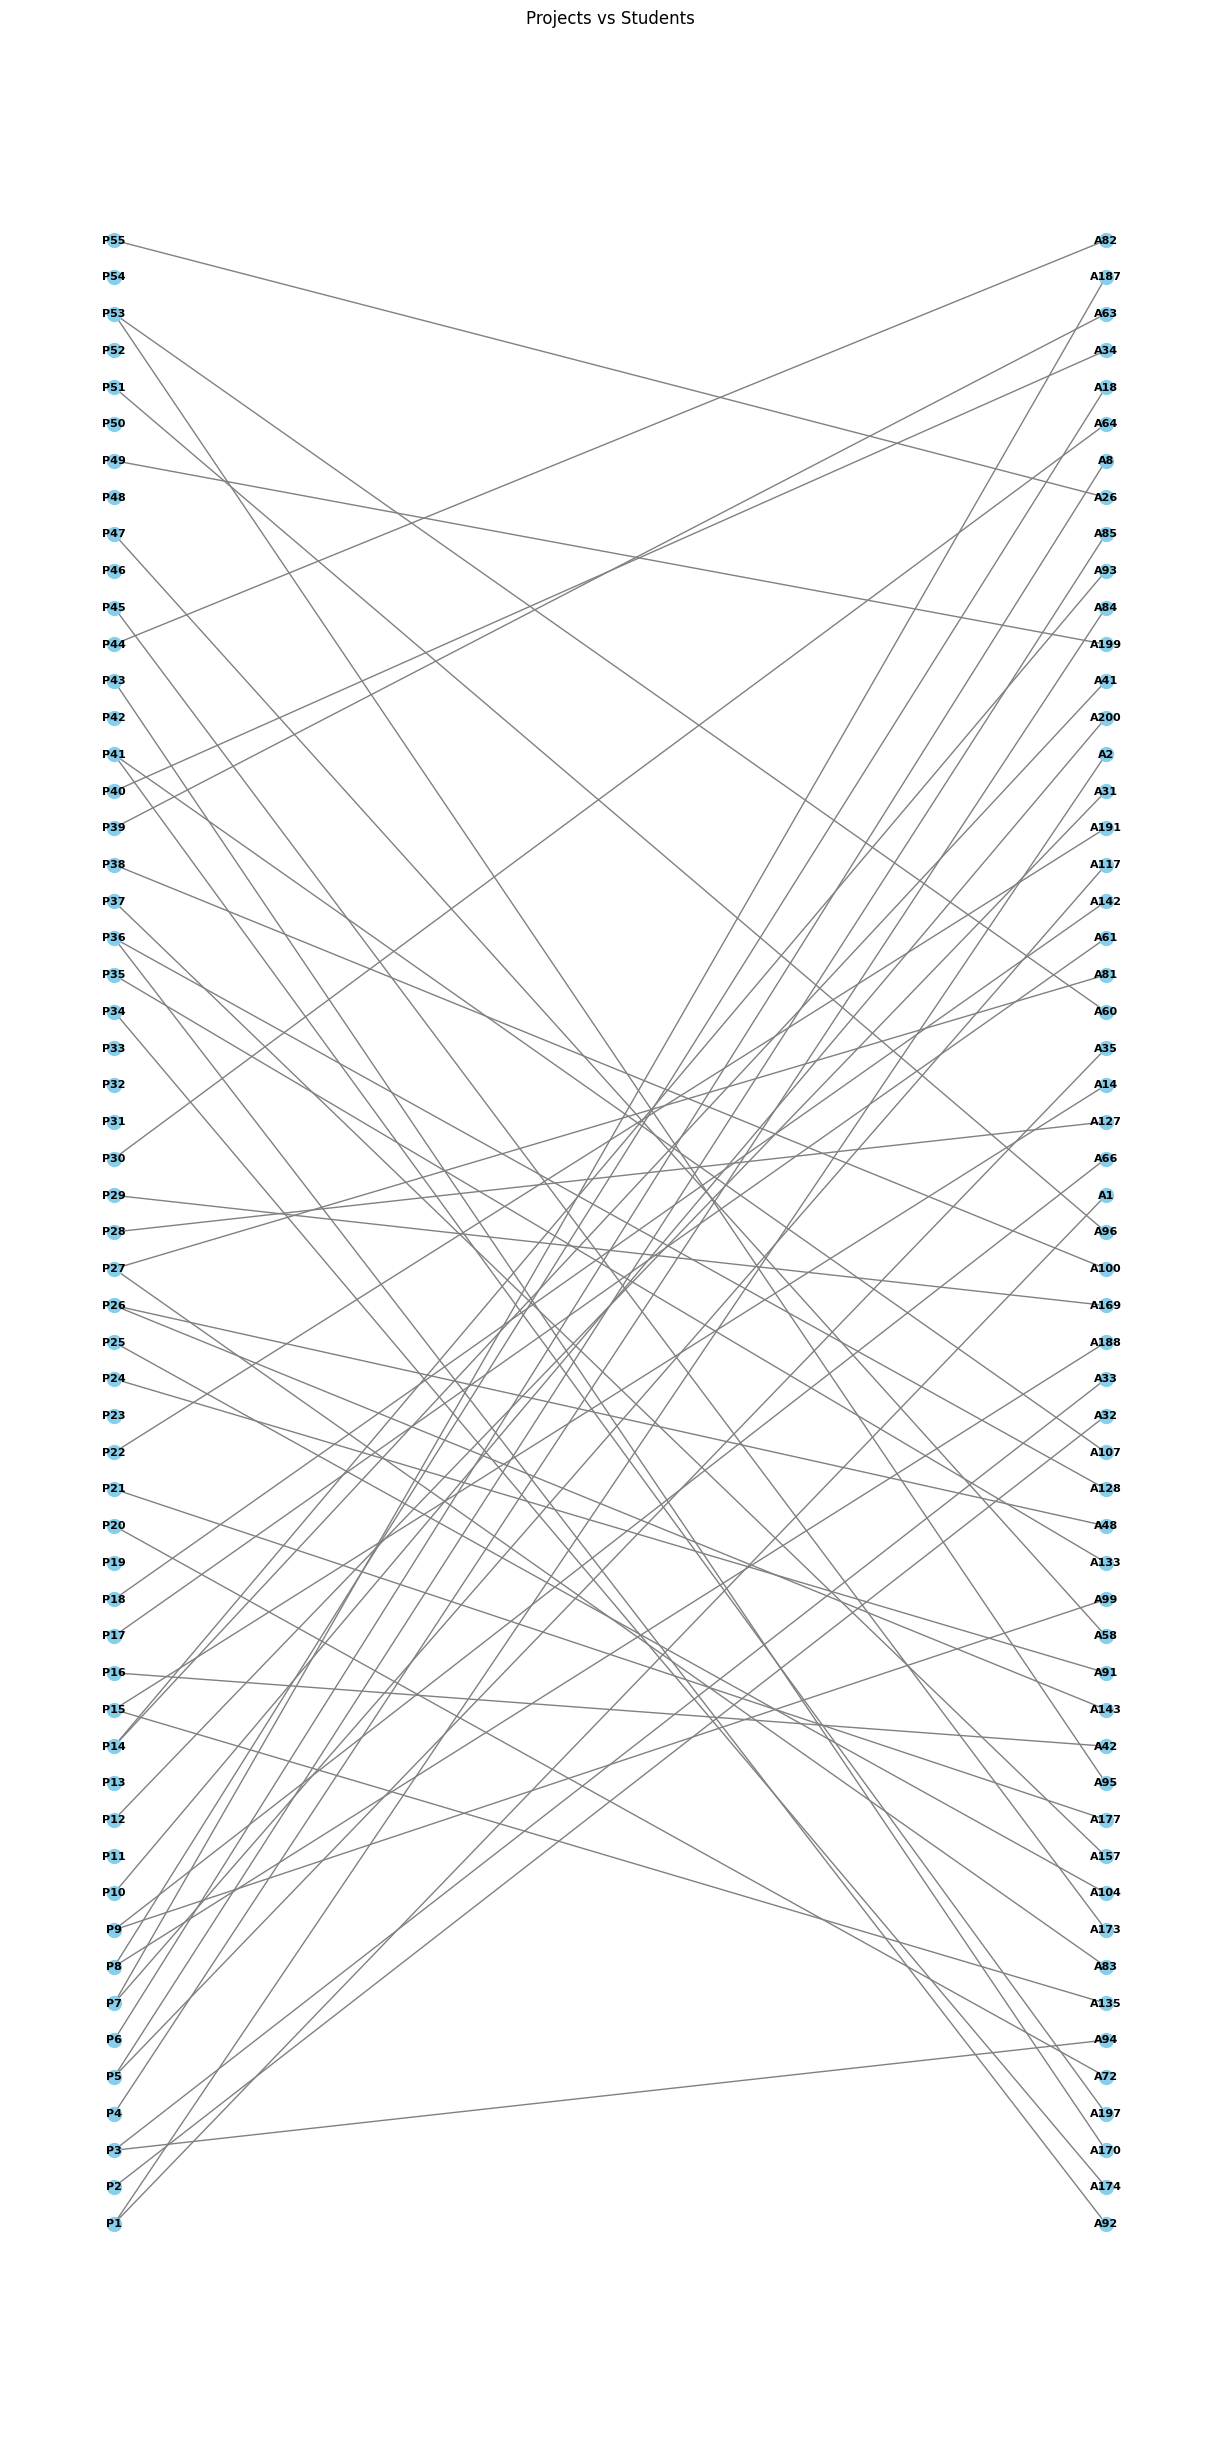

In [56]:
gale = GaleShapely(graph, report_connections=True, report_replacements=True)
gale.run()

matchings = len(list(filter(lambda x : x is not None, gale.students_match)))
print("Matchings:", matchings)
gale.view()

# Emparelhamento Estável e Máximo
Finalmente, podemos aproximar o emparelhamento máximo de modo empírico ao rodarmos o algoritmo 10 vezes. Como o algoritmo ordena os estudantes de modo aleatório antes da sua inicialização, a execução repetida tende a produzir o valor máximo. 

Iteração #1: 54
Iteração #2: 55
Iteração #3: 56
Iteração #4: 55
Iteração #5: 52
Iteração #6: 54
Iteração #7: 54
Iteração #8: 54
Iteração #9: 54
Iteração #10: 53
Número máximo de combinações: 56
Combinação com número máximo
(A1,P30) (A2,P1) (A8,P6) (A10,P10) (A14,P15) (A18,P8) (A22,P18) (A26,P55) (A31,P12) (A32,P20) (A33,P3) (A34,P40) (A35,P5) (A41,P14) (A42,P16) (A55,P35) (A60,P53) (A61,P17) (A62,P38) (A63,P39) (A66,P9) (A68,P36) (A73,P45) (A81,P27) (A82,P2) (A83,P27) (A84,P4) (A95,P53) (A96,P47) (A97,P41) (A100,P3) (A104,P25) (A114,P24) (A117,P7) (A127,P28) (A128,P36) (A131,P14) (A142,P26) (A143,P26) (A144,P22) (A149,P9) (A153,P43) (A154,P15) (A157,P37) (A159,P49) (A160,P5) (A169,P29) (A174,P34) (A177,P21) (A187,P7) (A188,P8) (A197,P41) (A200,P1) 


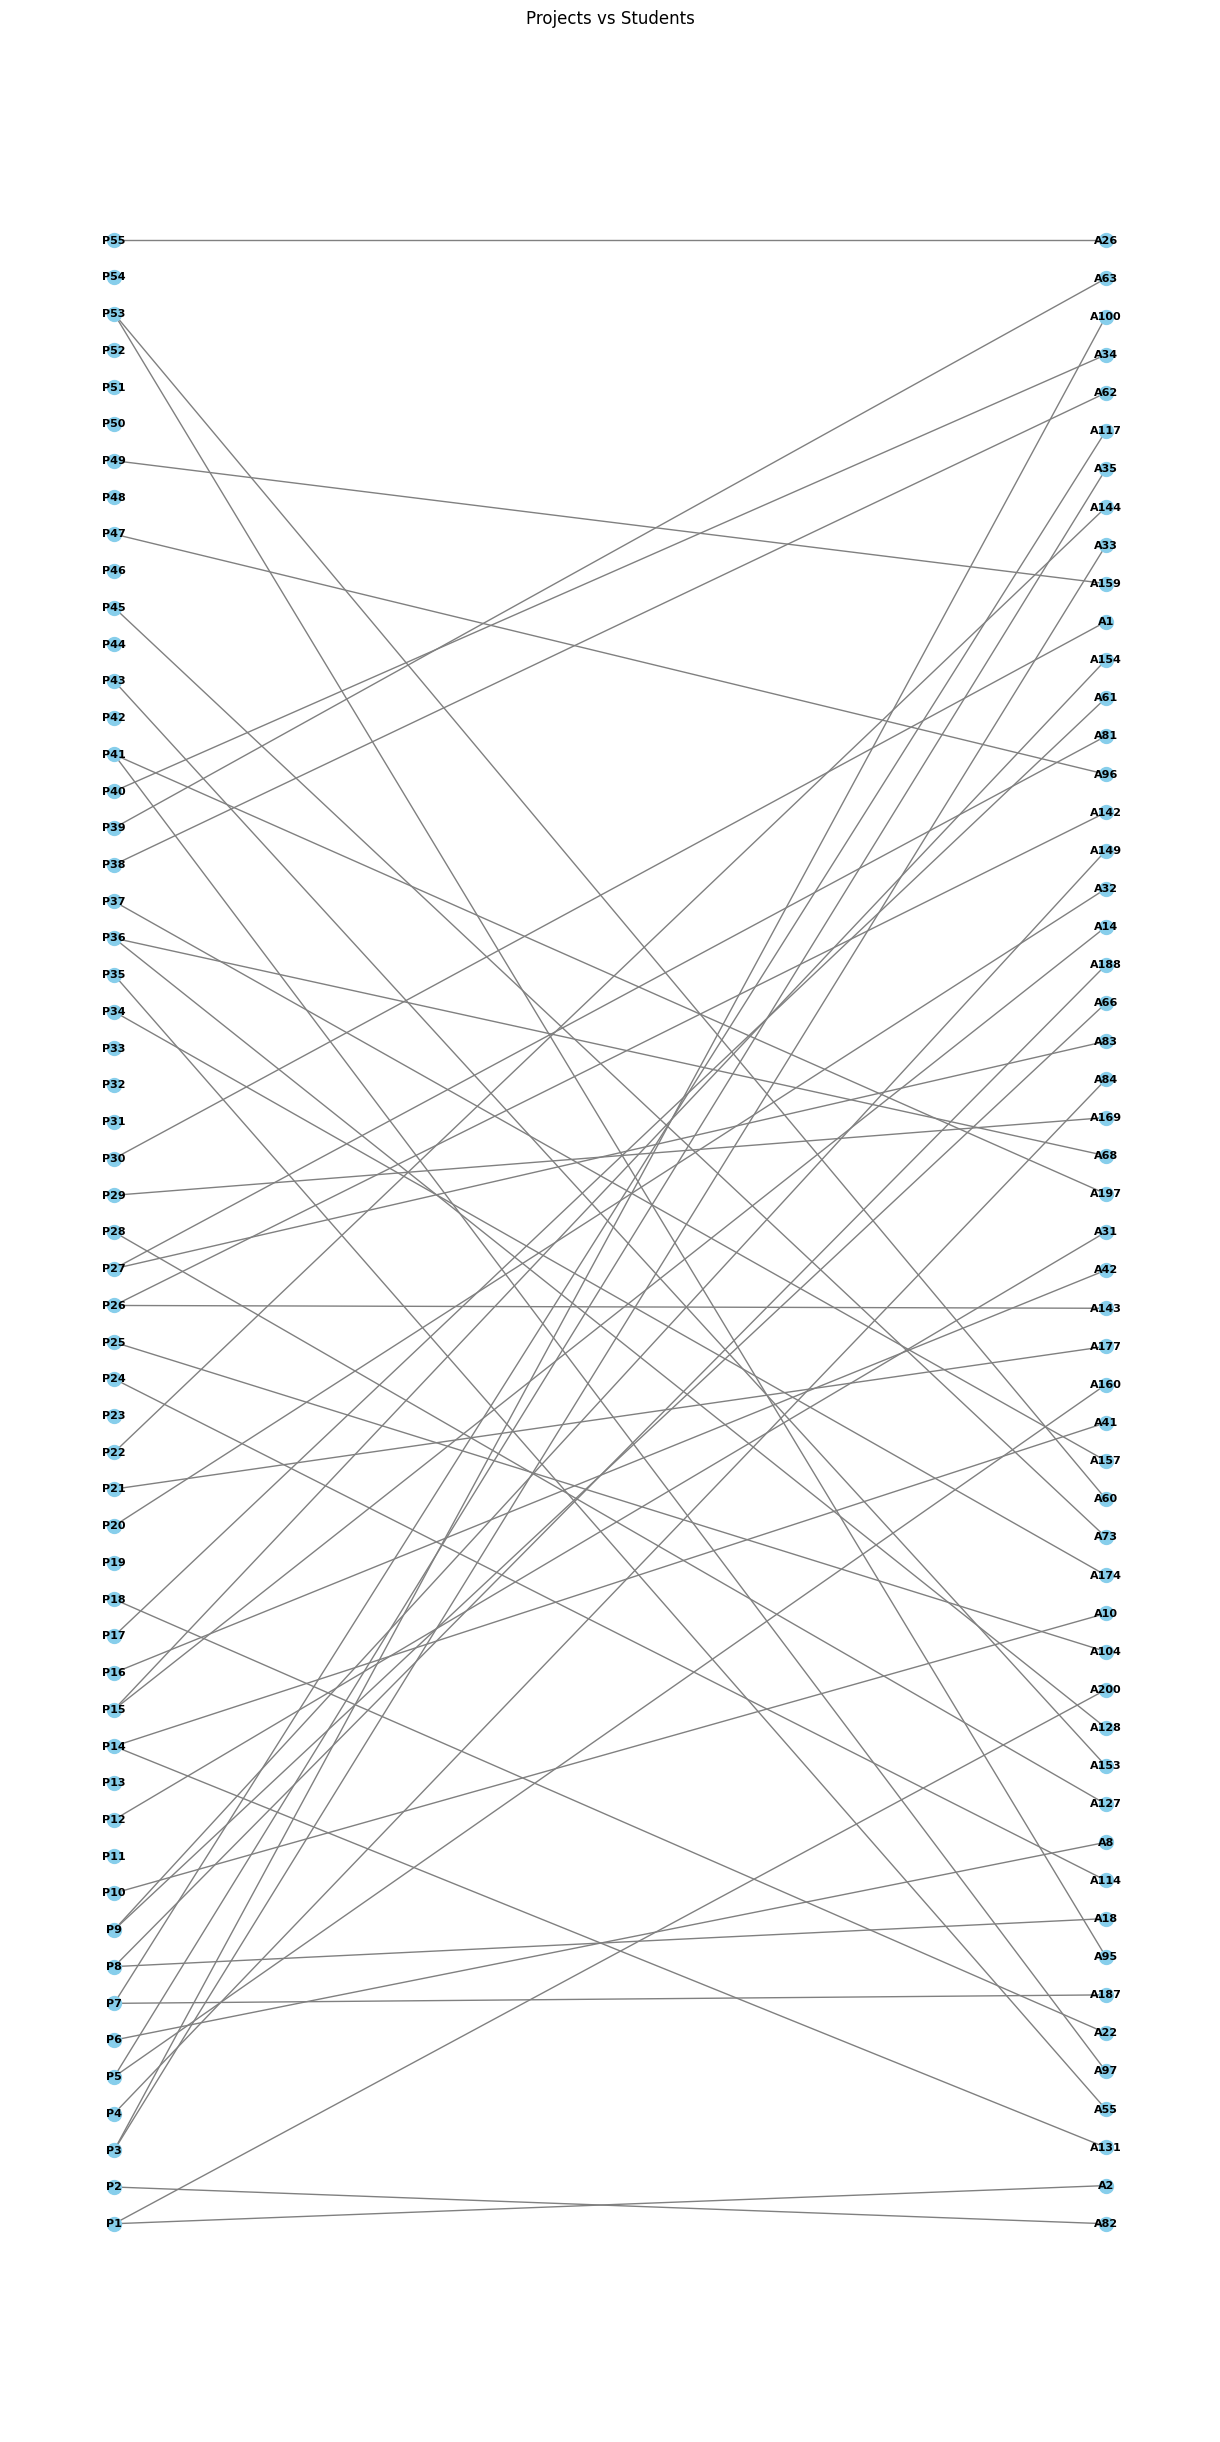

In [63]:
max_num = -1
max_match = None
for i in range(10):
    # Apenas veremos as mudanças de 
    gale = GaleShapely(graph)
    gale.run()


    matchings = len(list(filter(lambda x : x is not None, gale.students_match)))
    print(f"Iteração #{i+1}:", matchings)

    if matchings > max_num:
        max_num = matchings
        max_match = gale

print("Número máximo de combinações:", max_num)
print("Combinação com número máximo")
for j, project in enumerate(gale.students_match):
    if project is not None:
        print(f"({gale.graph.students[j].code},{project.code})", end=" ")
print()

gale.view()

# Número Máximo (10,000x)
Executando 10,000x conseguimos um valor ainda maior.

Número máximo de combinações: 58
Combinação com número máximo
(A1,P1) (A2,P1) (A8,P6) (A18,P47) (A26,P55) (A31,P12) (A32,P2) (A33,P3) (A34,P40) (A35,P5) (A42,P16) (A55,P35) (A56,P36) (A60,P53) (A61,P37) (A62,P8) (A63,P39) (A64,P30) (A69,P29) (A81,P17) (A82,P27) (A83,P27) (A84,P4) (A85,P5) (A93,P26) (A95,P53) (A98,P26) (A99,P9) (A100,P38) (A107,P41) (A111,P34) (A114,P15) (A117,P7) (A127,P28) (A130,P20) (A131,P14) (A134,P25) (A135,P15) (A144,P22) (A147,P3) (A151,P14) (A155,P45) (A157,P18) (A159,P49) (A168,P36) (A169,P9) (A175,P24) (A177,P21) (A187,P7) (A188,P8) (A196,P43) (A197,P41) (A200,P10) 


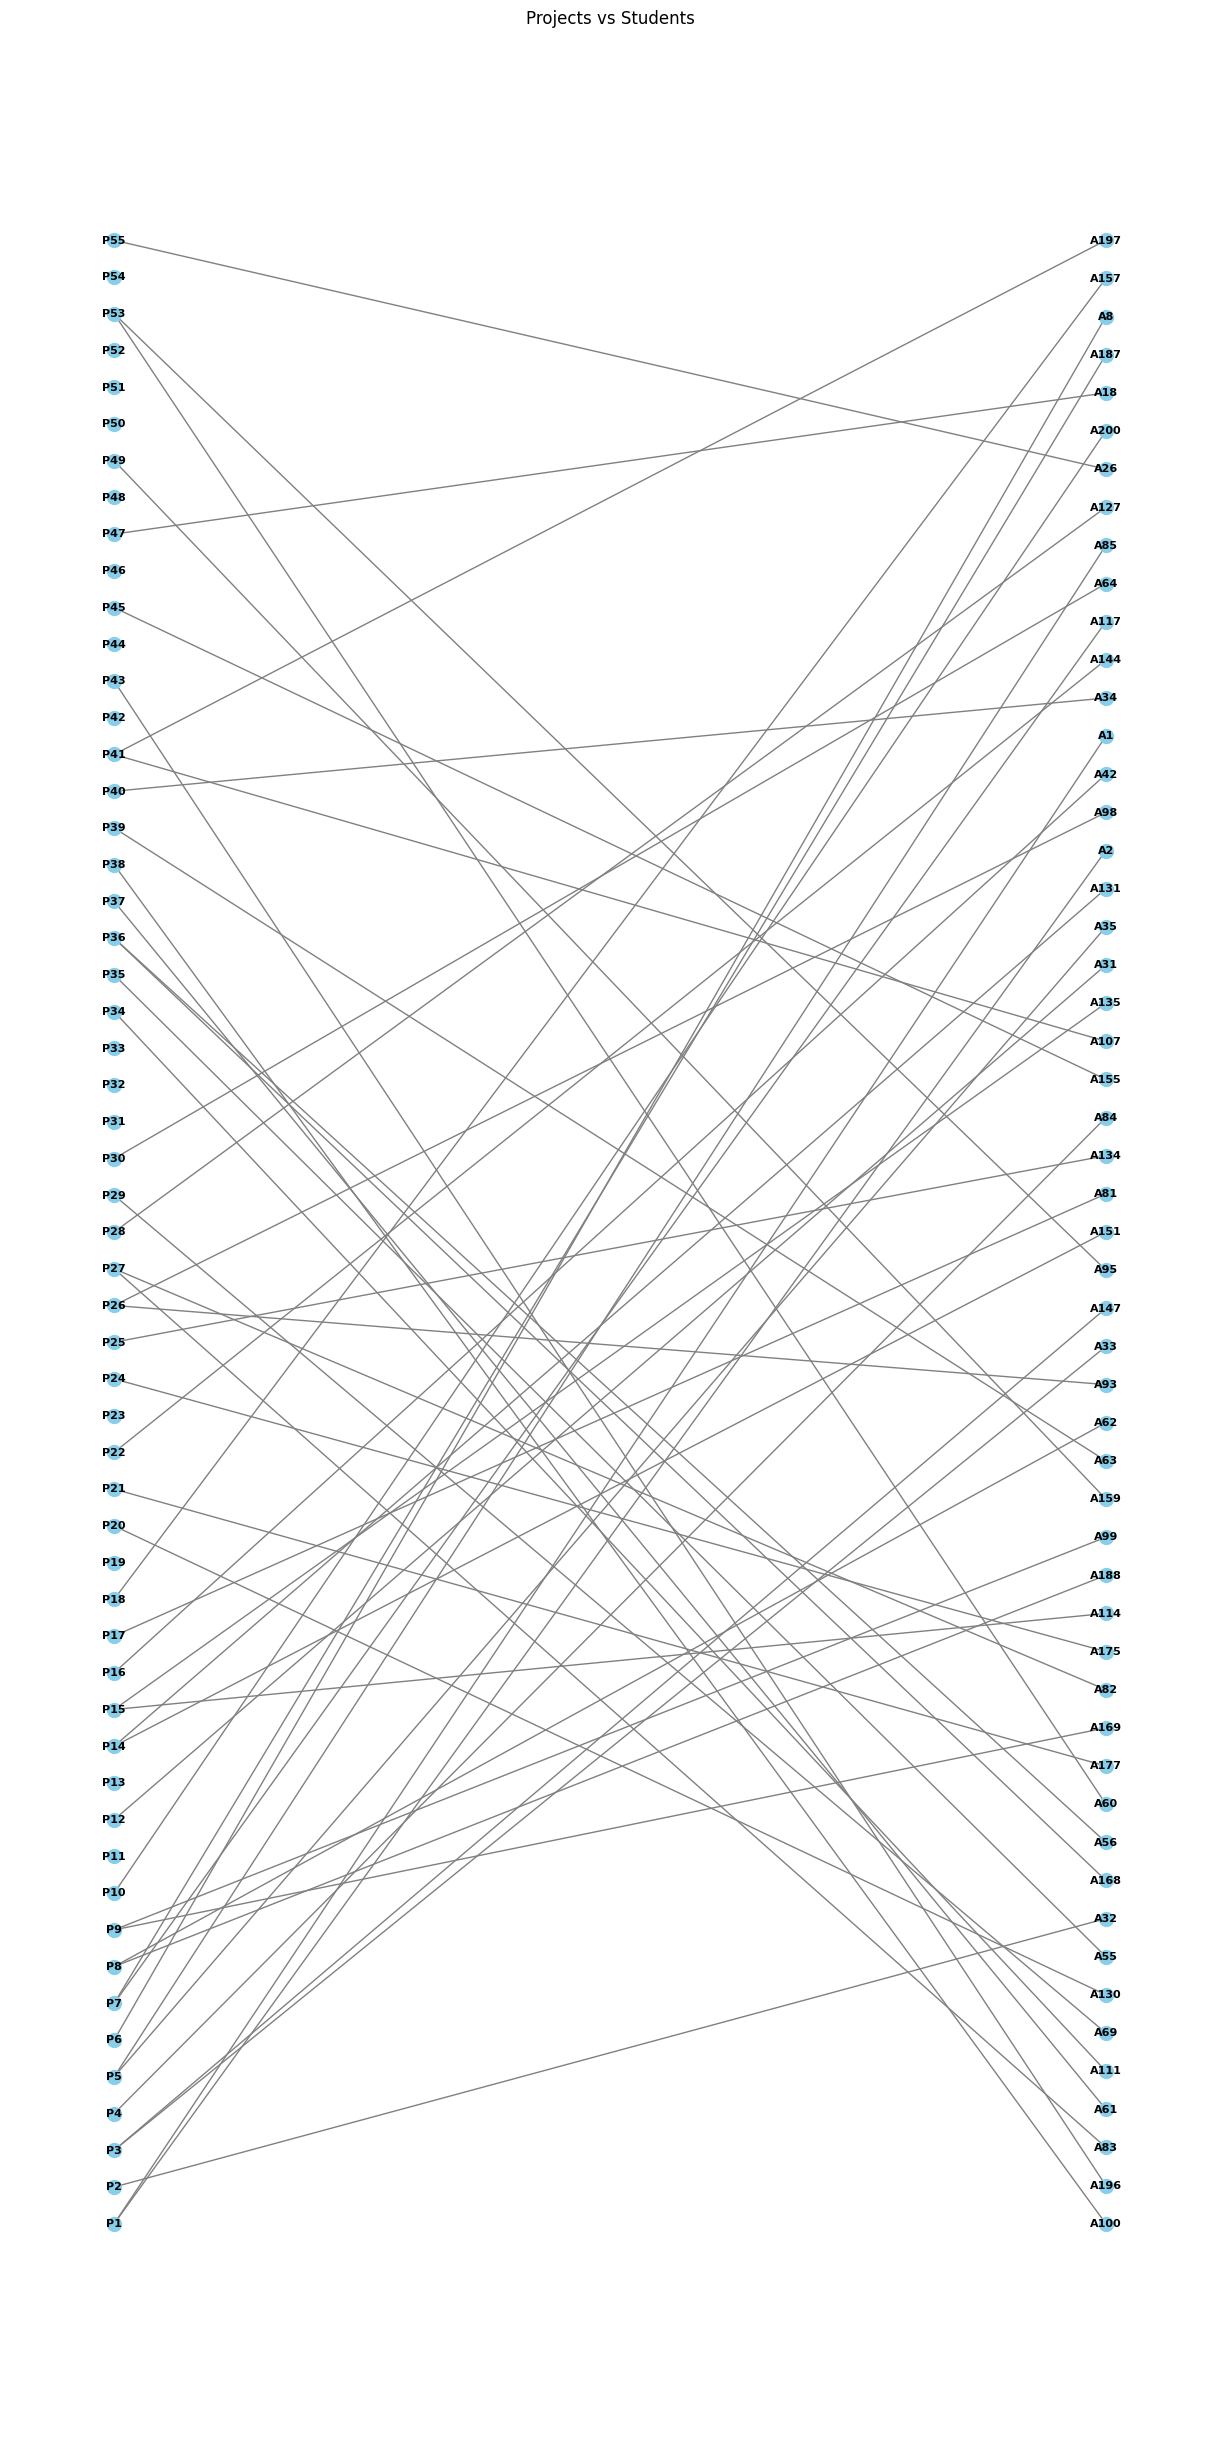

In [64]:
max_num = -1
max_match = None
for i in range(10_000):
    # Apenas veremos as mudanças de 
    gale = GaleShapely(graph)
    gale.run()

    matchings = len(list(filter(lambda x : x is not None, gale.students_match)))
    if matchings > max_num:
        max_num = matchings
        max_match = gale

print("Número máximo de combinações:", max_num)
print("Combinação com número máximo")
for j, project in enumerate(gale.students_match):
    if project is not None:
        print(f"({gale.graph.students[j].code},{project.code})", end=" ")
print()

gale.view()